# 1 背景与目的

基于Airbnb数据集，对特征进行统计/可视化分析，完成特征工程工作，最后通过XGB数据建模输出价格预测结果。数据来源:https://tianchi.aliyun.com/competition/entrance/231715/introduction

# 2 特征工程

## 2.1 数据预处理

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas_profiling
import warnings 
warnings.filterwarnings('ignore')
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
config = {
    "font.family":'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)
sns.set_style("ticks") # dark/white/darkgrid/whitegrid

In [31]:
df1=pd.read_csv("listings.csv")
df2=pd.read_csv("reviews_detail.csv")

In [99]:
df2=pd.read_csv("reviews_detail.csv")

### 2.1.1 格式清洗

In [10]:
#主要看看各特征数据格式是否一致。是否有乱码等不干净数据。
df1.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,792,1,89,2019-03-04,0.85,9,341
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68434,117.17231,Private room,1201,1,2,2017-10-08,0.10,4,0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,NaN,东城区,39.93213,116.42200,Entire home/apt,389,3,259,2019-02-05,2.70,1,93


In [11]:
df1.tail(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
28449,33950006,临近地铁温馨网红风小屋一居室,141786513,昊,NaN,朝阳区 / Chaoyang,39.89733,116.50473,Entire home/apt,329,1,0,NaN,NaN,1,363
28450,33950535,"3. 老国展,三元桥地铁,静安东里大床房",213500128,晓征,NaN,朝阳区 / Chaoyang,39.95988,116.45187,Private room,188,1,0,NaN,NaN,6,84
28451,33954414,"密码锁自行入住,隐私安全,丰台宋家庄交通枢纽站,去往北京站北京南站,天安门故宫,长城水魔方,...",252799678,超,NaN,丰台区 / Fengtai,39.84714,116.43481,Entire home/apt,295,1,0,NaN,NaN,6,180


In [9]:
df1.describe(include=["O"])

,name,host_name,neighbourhood,room_type,last_review
count,28451,28452,28452,28452,17294
unique,27594,6628,16,3,883
top,距离首都机场T3航站楼3公里/新国展｡免费接送机早餐;2x2米舒适大床｡全时京味餐厅名厨料理...,美婷,朝阳区 / Chaoyang,Entire home/apt,2019-04-07
freq,28,223,10810,16955,1067


neighbourhood中英文混合，且区县混用，目前北京市统一改县为区，应该统一表达。neighbourhood和room_type唯一值比较小，比较符合一般认知。
数据类型方面，ID类特征应该为分类型数据，last_review应为日期型数据。

In [52]:
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub("[A-Za-z0-9/]", "",x)) #滤除非汉字部分
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub("县", "区",x)) #替换
df1["neighbourhood"]=df1["neighbourhood"].apply(lambda x:re.sub(" ", "",x)) #消除空格
df1.id=df1.id.astype("object") #数据类型转换
df1.host_id=df1.host_id.astype("object") #数据类型转换
df1.last_review=pd.to_datetime(df1.last_review) #数据类型转换

In [14]:
df2.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...


In [16]:
df2.tail(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
202096,33891613,438182693,2019-04-16,255994654,天佑,"房间布置明亮温暖而别有风格,指引周到而迅速,房间内设施齐全､空间宽敞!"
202097,33892088,438119657,2019-04-16,255993753,志强,"各方面这个价位性价比是非常之高了,房东人也很好,交通便利,我个人是很满意的,有机会还会来｡"
202098,33925874,438572523,2019-04-17,256375057,玲,The host canceled this reservation 13 days bef...


df2的数据以非结构化数据为主，comments中英文混合不利于提取特征，可以考虑将中英文进行分割，再提取对应的评论情感正向指数，评论字符数等作为新特征。

In [102]:
df2.id=df2.id.astype('object')
df2.reviewer_id=df2.reviewer_id.astype("object")
df2.listing_id=df2.listing_id.astype("object")
df2.date=pd.to_datetime(df2.date)

### 2.1.2 缺失值处理

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28452 entries, 0 to 28451
Data columns (total 16 columns):
id                                28452 non-null int64
name                              28451 non-null object
host_id                           28452 non-null int64
host_name                         28452 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     28452 non-null object
latitude                          28452 non-null float64
longitude                         28452 non-null float64
room_type                         28452 non-null object
price                             28452 non-null int64
minimum_nights                    28452 non-null int64
number_of_reviews                 28452 non-null int64
last_review                       17294 non-null object
reviews_per_month                 17294 non-null float64
calculated_host_listings_count    28452 non-null int64
availability_365                  28452 non-null int64
dt

In [20]:
df1.isnull().sum()

id                                    0
name                                  1
host_id                               0
host_name                             0
neighbourhood_group               28452
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11158
reviews_per_month                 11158
calculated_host_listings_count        0
availability_365                      0
dtype: int64

name具有一个缺失样本，缺失比例较小，考虑直接删除该条记录。而last_review和reviews_per_month拥有相同比例的缺失值，考虑缺失类型为非完全随机缺失，且缺失量较大，但小于50%，考虑根据特征属性进行填充。
last_review填充众数，而reviews_per_month填充0.

In [39]:
#计算特征的缺失率；删除缺失率超过50%的特征；删除缺失率小于2%的特征对应的空值样本
def delete_feature(df):
    df_=df.copy()
    N = df.shape[0]  # 样本数
    no_nan_count = df.count().to_frame().T  # 每一维特征非缺失值的数量
    del_feature, save_feature,feature_loss_rate = [], [],[]
    for col in no_nan_count.columns.tolist():
        loss_rate = (N - no_nan_count[col].values[0])/N  # 缺失率
        if loss_rate > 0:
            feature_loss_rate.append((col,loss_rate))
        if 0.05>=loss_rate > 0: # 缺失率小于 2% 时，将这一维特征对应的空值样本删除
            df_=df[df[col].notnull()]
        if loss_rate > 0.5:  # 缺失率大于 50% 时，将这一维特征删除
            del_feature.append(col)
        else:
            save_feature.append(col)
    return feature_loss_rate,df_[save_feature]

#删除非缺失值数大于thresh(thresh=80%的特征数)的样本
def delete_sample(df): 
    df_ = df.dropna(thresh=int(df.shape[1]*0.8))
    return df_

In [40]:
feature_loss_rate=delete_feature(df1)[0]
df1=delete_feature(df1)[1]
df1=delete_sample(df1)

In [44]:
df1.last_review=df1.last_review.fillna(df1.last_review.mode()[0])
df1.reviews_per_month=df1.reviews_per_month.fillna(value=0)

In [46]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202099 entries, 0 to 202098
Data columns (total 6 columns):
listing_id       202099 non-null int64
id               202099 non-null int64
date             202099 non-null object
reviewer_id      202099 non-null int64
reviewer_name    202093 non-null object
comments         201983 non-null object
dtypes: int64(3), object(3)
memory usage: 9.3+ MB


In [100]:
df2=delete_feature(df2)[1]
df2=delete_sample(df2)

In [101]:
df2.reviewer_name=df2.reviewer_name.fillna(value="未留名")

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201983 entries, 0 to 202098
Data columns (total 6 columns):
listing_id       201983 non-null int64
id               201983 non-null int64
date             201983 non-null object
reviewer_id      201983 non-null int64
reviewer_name    201983 non-null object
comments         201983 non-null object
dtypes: int64(3), object(3)
memory usage: 10.8+ MB


### 2.1.3 异常值处理

In [53]:
df1.describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99]) #数值型数据统计结果

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,28451.000000,28451.000000,28451.000000,28451.000000,28451.000000,28451.000000,28451.000000,28451.000000
mean,39.983232,116.442008,610.873396,2.729746,7.103406,0.802217,12.818706,220.337071
std,0.186984,0.204795,1622.609504,17.921244,16.815310,1.391039,29.261751,138.430490
min,39.455810,115.473390,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
5%,39.798705,116.189500,107.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,39.897335,116.355290,235.000000,1.000000,0.000000,0.000000,2.000000,87.000000
50%,39.930910,116.434670,389.000000,1.000000,1.000000,0.200000,5.000000,209.000000
75%,39.990470,116.491125,577.000000,1.000000,6.000000,1.000000,11.000000,361.000000
95%,40.447150,116.686040,1691.000000,5.000000,35.000000,3.675000,45.000000,365.000000
99%,40.656795,117.267885,4395.500000,30.000000,84.000000,6.455000,210.000000,365.000000


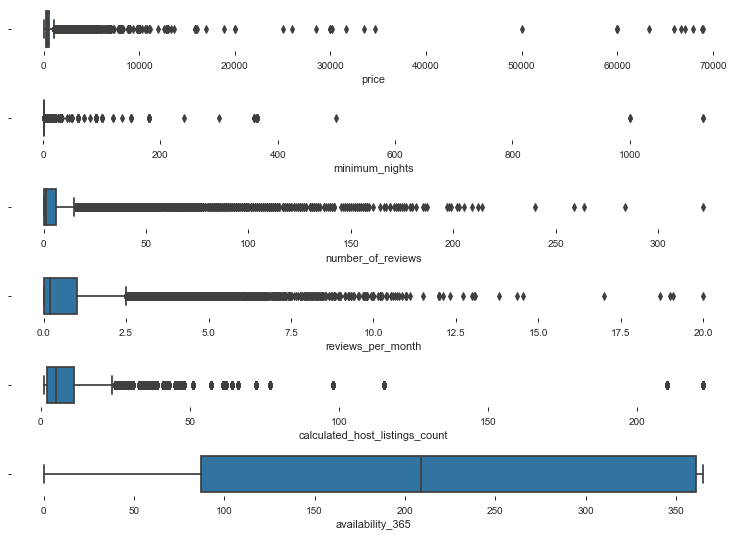

In [54]:
#箱型图，获取数据大致分布情况，查看离群点信息
subsets=['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
fig,axes=plt.subplots(len(subsets),1,figsize=(13,9))
plt.subplots_adjust(hspace=1)
for i,subset in enumerate(subsets):
    sns.boxplot(df1[subset],ax=axes[i],orient='h')

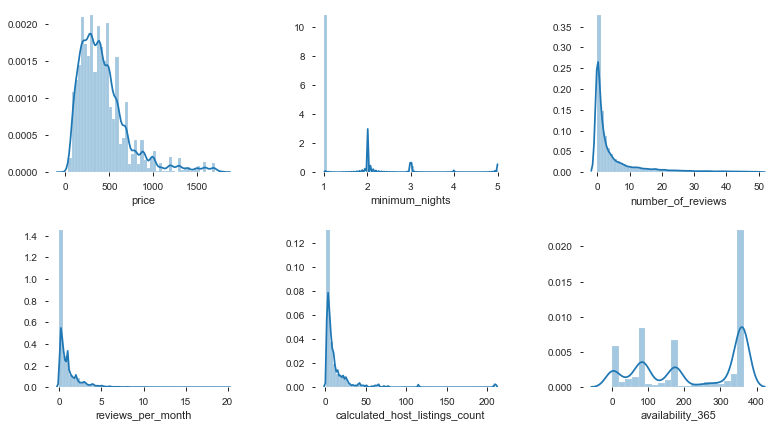

In [55]:
#直方图，获取数据大致分布情况，查看集中信息
fig2,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=plt.subplots(2,3,figsize=(13,7))
axes2=[ax1,ax2,ax3,ax4,ax5,ax6]
plt.subplots_adjust(hspace=.3, wspace=.4)
data=df1[(df1.price<=1778) & (df1.minimum_nights<=5) & (df1.number_of_reviews<=50)]
data=data.dropna(how="any")
for i,subset in enumerate(subsets):
    sns.distplot(data[subset],ax=axes2[i]) 

price为0的记录考虑删除，价格极差很大，标准差系数达到2.65，对于高于10000的记录需要进一步诊断是否异常，价格很高有可能房源是别墅等豪宅。
minimum_nights：95%在5以内，99%在30以内，最大值达到1125，意味着这个房源至少需要连续订阅1125个晚上，与常理不是很吻合,需要进一步诊断。
number_of_reviews:极差很大，99%位数与max差异也很大，需要查看是否存在异常。
availability_365：应在1~365之间，在此区间外的数据应该删除。

In [56]:
df1[df1.price>=10000].room_type.value_counts()

Entire home/apt    33
Private room       11
Shared room         4
Name: room_type, dtype: int64

在超过10000的高价房源中，有4个房源为合租类型，与现实场景不太吻合，因此考虑将此记录移除。同时，对高价房源中房屋类型为单租且缺失值较多的记录也予以删除。

In [61]:
df1=df1[~((df1.price>10000)&(df1.room_type.isin(["Private room","Shared room"])))]
df1=df1[~((df1.minimum_nights>365)&(df1.price>df1.price.quantile(q=0.95)))]
df1=df1[df1["price"]>0]
df1=df1[(0<df1["availability_365"]) & (df1["availability_365"]<=365) ]

In [77]:
df1.shape[0]

25811

In [84]:
#基于IQR进行过滤
def IQRFilter(df,colnames): 
    # 下四分位数值、中位数，上四分位数值
    for col in colnames:
        Q1, median, Q3 = np.percentile(df[col].values, (25, 50, 75), interpolation='midpoint')
        # 四分位距
        IQR = Q3 - Q1
        # 内限
        inner = [Q1-1.5*IQR, Q3+1.5*IQR]
        # 外限
        outer = [Q1-3.0*IQR, Q3+3.0*IQR] 
        # 过滤极端异常值
        df=df[(df[col].values<outer[1]) & (df[col].values>outer[0]) ]
    return df

In [85]:
dfnew=IQRFilter(df1,["number_of_reviews","reviews_per_month"])

In [87]:
dfnew.shape[0]

22775

基于IQR方法过滤的数据量达将近12%,因此考虑先不过滤，后续在测试结果评估中再对比。

## 2.2 特征构造

### 2.2.1 新特征构造

#### 构造评论正面指数和评论长度

In [169]:
df2new=df2.copy()

In [167]:
def abstractEnglish(x):
    import re
    if bool(re.search("[\u4e00-\u9fa5]", x)):
        return "None"
    else:
        return x


In [168]:
def abstractChinese(x):
    import re
    if bool(re.search("[\u4e00-\u9fa5]", x)):
        return x
    else:
        return "无"


In [170]:
df2new["Chinese_comments"]=df2new.comments.apply(lambda x: abstractChinese(x))

In [171]:
df2new["English_comments"]=df2new.comments.apply(lambda x: abstractEnglish(x))

In [177]:
df2new["Chinese_comments_len"]=df2new.Chinese_comments.apply(lambda x: len(x))

In [178]:
df2new["English_comments_len"]=df2new.English_comments.apply(lambda x: len(x))

In [179]:
df2new.tail(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,Chinese_comments,English_comments,Chinese_comments_len,English_comments_len
202094,33889408,438178936,2019-04-16,255996319,小倩,"很不错的,去之前提供的位置信息特别详细,房东有心了,位置很便利,设施也很齐全,非常好的一次住...","很不错的,去之前提供的位置信息特别详细,房东有心了,位置很便利,设施也很齐全,非常好的一次住...",None,50,4
202095,33890728,438182720,2019-04-16,255995373,志辉,"非常棒的房子,住的很开心｡ 地址位置很方便, 房间布置和装修都很奈斯,沙发床特别舒服哈哈","非常棒的房子,住的很开心｡ 地址位置很方便, 房间布置和装修都很奈斯,沙发床特别舒服哈哈",None,44,4
202096,33891613,438182693,2019-04-16,255994654,天佑,"房间布置明亮温暖而别有风格,指引周到而迅速,房间内设施齐全､空间宽敞!","房间布置明亮温暖而别有风格,指引周到而迅速,房间内设施齐全､空间宽敞!",None,35,4
202097,33892088,438119657,2019-04-16,255993753,志强,"各方面这个价位性价比是非常之高了,房东人也很好,交通便利,我个人是很满意的,有机会还会来｡","各方面这个价位性价比是非常之高了,房东人也很好,交通便利,我个人是很满意的,有机会还会来｡",None,45,4
202098,33925874,438572523,2019-04-17,256375057,玲,The host canceled this reservation 13 days bef...,无,The host canceled this reservation 13 days bef...,1,88


In [131]:
from textblob import TextBlob #英文文本情感分析库
def CalPolarity(text):
    blob=TextBlob(text)
    return blob.sentiment.polarity #输出该文本的情感极数（-1~1）

In [ ]:
df2new["Polarity"]=df2new.English_comments.apply(lambda x: CalPolarity(x) )

In [ ]:
from snownlp import SnowNLP #中文文本情感分析库
def CalProbability(text): 
    s = SnowNLP(text)
    return s.sentiments #输出该文本为正面评价的概率

In [ ]:
df2new["ProbaPositive"]=df2new.Chinese_comments.apply(lambda x: CalProbability(x) )

In [234]:
df2new=pd.read_csv("df2new_pro.csv")

In [236]:
df2new=df2new.iloc[:,2:]

In [237]:
df2new.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Chinese_comments,English_comments,Polarity,ProbaPositive,English_comments_len,Chinese_comments_len
0,44054,84748,2010-08-25,207019,Jarrod,Sev was very helpful. Sev showed us where to ...,无,Sev was very helpful. Sev showed us where to ...,0.333333,0.409149,200,1
1,44054,118384,2010-10-13,218723,Kimberly,We arrived in Beijing very early in the mornin...,无,We arrived in Beijing very early in the mornin...,0.147187,0.409149,865,1
2,44054,436978,2011-08-11,609177,Emma,It is a really massive apartment and really co...,无,It is a really massive apartment and really co...,0.483333,0.409149,309,1
3,44054,1118657,2012-04-12,1787536,Andreyna,"Sev was incredibly helpful, showed us around t...",无,"Sev was incredibly helpful, showed us around t...",0.475000,0.409149,396,1
4,44054,2140650,2012-08-30,1179565,Frances,The appartment was ideal for our party of 6 ad...,无,The appartment was ideal for our party of 6 ad...,0.366667,0.409149,334,1


#### 构造房源描述长度

In [181]:
df1["Chinese_name"]=df1.name.apply(lambda x: abstractChinese(x))
df1["Chinese_name_len"]=df1.Chinese_name.apply(lambda x: len(x))
df1["English_name"]=df1.name.apply(lambda x: abstractEnglish(x))
df1["English_name_len"]=df1.English_name.apply(lambda x: len(x))

#### 房屋类型特征

房屋类型与其他特征以及标签都紧密相关，因此基于房屋类型所衍生出的统计特征可能有价值。

In [185]:
df1.groupby("room_type")[["room_type","price","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]].agg({"room_type":'count','price':'median','minimum_nights':'mean','number_of_reviews':'mean','reviews_per_month':'mean','availability_365':'mean'}).sort_values(by="number_of_reviews",ascending=False)

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
room_type,,,,,,
Private room,8606,248,2.349291,7.989891,0.784510,230.028585
Entire home/apt,15759,476,2.578336,7.037756,0.902845,248.198807
Shared room,1446,107,2.825726,6.798755,0.625539,258.352697


In [218]:
def meanFeature(df,groupbycol,clonames):
    for col in clonames:
        newF1 = df1.groupby([groupbycol])[col].mean().to_frame().rename(columns={groupbycol:groupbycol+"_"+col+'__mean'}).reset_index()
        df = pd.merge(df, newF1, on=[groupbycol], how='inner')
    return df

In [221]:
newF1 = df1.groupby(['room_type'])['room_type'].count().to_frame().rename(columns={'room_type':'room_type_count'}).reset_index()
df1new = pd.merge(df1, newF1, on=['room_type'], how='inner')

In [222]:
df1new=meanFeature(df1new,'room_type',["minimum_nights","number_of_reviews","reviews_per_month","availability_365"])

#### 区域特征

In [186]:
df1.groupby("neighbourhood")[["neighbourhood","price","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]].agg({'neighbourhood':'count','price':'median','minimum_nights':'mean','number_of_reviews':'mean','reviews_per_month':'mean','availability_365':'mean'}).sort_values(by="number_of_reviews",ascending=False)

,neighbourhood,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
neighbourhood,,,,,,
东城区,3050,497.0,2.268525,14.908525,1.393990,214.475082
西城区,1522,463.0,2.319974,9.193824,1.127306,232.201708
朝阳区,9639,389.0,2.997718,8.607117,0.976222,238.049590
海淀区,2859,336.0,3.061910,7.045820,0.909612,254.000350
丰台区,1625,349.0,2.035077,5.368615,0.744634,254.444923
石景山区,187,362.0,1.818182,4.064171,0.612299,264.042781
顺义区,859,382.0,2.812573,3.913853,0.620081,253.870780
大兴区,770,329.0,2.263636,3.859740,0.499143,267.297403
昌平区,908,336.0,2.757709,2.674009,0.400044,252.180617


In [223]:
newF1 = df1.groupby(['neighbourhood'])['neighbourhood'].count().to_frame().rename(columns={'neighbourhood':'neighbourhood_count'}).reset_index()
df1new = pd.merge(df1new, newF1, on=['neighbourhood'], how='inner')

In [224]:
df1new=meanFeature(df1new,'neighbourhood',["minimum_nights","number_of_reviews","reviews_per_month","availability_365"])

#### number_of_reviews离散为不受欢迎/较受欢迎/受欢迎/极受欢迎五个类别

In [225]:
def discretization(df,col):
    Q1, median, Q3 = np.percentile(df[col].values, (25, 50, 75), interpolation='midpoint')
    df[col+"_discretization"]=1
    df.loc[df[col]<Q1,col+"_discretization"]=0
    df.loc[((median>df[col]) & (df[col]>=Q1)),col+"_discretization"]=1
    df.loc[((median<=df[col]) & (df[col]<=Q3)),col+"_discretization"]=2
    df.loc[df[col]>Q3,col+"_discretization"]=3
    return df

In [229]:
df1new=discretization(df1new,"number_of_reviews")

In [230]:
df1new.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights_x,...,minimum_nights_y,number_of_reviews_y,reviews_per_month_y,availability_365_y,neighbourhood_count,minimum_nights,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_discretization
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区,39.89503,116.45163,Entire home/apt,792,1,...,2.578336,7.037756,0.902845,248.198807,9639,2.997718,8.607117,0.976222,238.04959,2
1,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区,39.93668,116.43798,Entire home/apt,537,1,...,2.578336,7.037756,0.902845,248.198807,9639,2.997718,8.607117,0.976222,238.04959,2
2,282825,Large 2 BR Apt in a great location,1466681,Florence,朝阳区,39.93712,116.45089,Entire home/apt,637,3,...,2.578336,7.037756,0.902845,248.198807,9639,2.997718,8.607117,0.976222,238.04959,2
3,287026,Studio in downtown Beijing #2,1456491,Vera,朝阳区,39.94115,116.44122,Entire home/apt,416,1,...,2.578336,7.037756,0.902845,248.198807,9639,2.997718,8.607117,0.976222,238.04959,2
4,322292,Cozy studio in downtown Beijing,1456491,Vera,朝阳区,39.93849,116.44066,Entire home/apt,436,1,...,2.578336,7.037756,0.902845,248.198807,9639,2.997718,8.607117,0.976222,238.04959,2


#### 两表整合

In [240]:
DF=df2new.groupby("listing_id")["Polarity","ProbaPositive","English_comments_len","Chinese_comments_len"].mean()

In [291]:
df=pd.merge(df1new,DF,how="left",left_on="id",right_on=DF.index)

In [292]:
df=df.drop(['id','name','host_id','host_name','Chinese_name','English_name'],axis=1)

In [293]:
df["year"]=df.last_review.dt.year #日期数据钻取，以便时间序列分析
df["month"]=df.last_review.dt.month
df["weekday"]=df.last_review.dt.weekday #返回周几

In [294]:
df=df.drop(['last_review'],axis=1)

In [295]:
df.ProbaPositive=df.ProbaPositive.fillna(value=0.40914866581956777)
df.Chinese_comments_len=df.Chinese_comments_len.fillna(value=1)
df.Polarity=df.Polarity.fillna(value=0)
df.English_comments_len=df.English_comments_len.fillna(value=4)

In [296]:
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights_x,number_of_reviews_x,reviews_per_month_x,calculated_host_listings_count,availability_365_x,...,reviews_per_month,availability_365,number_of_reviews_discretization,Polarity,ProbaPositive,English_comments_len,Chinese_comments_len,year,month,weekday
0,朝阳区,39.89503,116.45163,Entire home/apt,792,1,89,0.85,9,341,...,0.976222,238.04959,2,0.205774,0.511484,181.415730,24.876404,2019,3,0
1,朝阳区,39.93668,116.43798,Entire home/apt,537,1,37,0.40,5,352,...,0.976222,238.04959,2,0.204663,0.491734,340.459459,12.297297,2018,8,2
2,朝阳区,39.93712,116.45089,Entire home/apt,637,3,107,1.26,1,78,...,0.976222,238.04959,2,0.345077,0.465642,369.934579,14.317757,2019,4,0
3,朝阳区,39.94115,116.44122,Entire home/apt,416,1,3,0.03,9,106,...,0.976222,238.04959,2,0.066618,0.409149,615.333333,1.000000,2012,9,4
4,朝阳区,39.93849,116.44066,Entire home/apt,436,1,11,0.13,9,361,...,0.976222,238.04959,2,0.444428,0.409149,354.636364,1.000000,2015,5,6


In [300]:
df.shape

(25811, 30)

In [266]:
df1new.shape

(25811, 30)

### 2.2.2 特征数据转换

最后，根据Quora的这个回答，并不是所有的算法都需要对特征做归一化和独热编码：

基于参数的模型需要做特征归一化的独热编码，如GLM、SVM、Neural Network。
基于距离的模型需要做特征归一化的独热编码，如KNN。
基于树的算法不需要做特征归一化和独热编码，如c4.5、Cart、Random Forrest、Bagging或Boosting。（看Kaggle案例的时候发现有人用XGBoost的时候做了独热编码，所以这一块不太确定到底要不要做独热编码……）

#### 类别数据处理

##### 序号编码

In [310]:
#所有分类型变量都要进行序号编码，才能输入模型
#序号编码，通常用来处理类别间具有大小关系的数据，比如成绩(高中低)
#如果类别间不具有大小关系，则需要在序号编码后进一步进行独热编码
def get_lables(df,cols):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in cols:
        df[col]=le.fit_transform(df[col].values)
    return df

In [314]:
df=get_lables(df,["neighbourhood","room_type"])

##### 独热编码

独热编码(One-hot Encoding)，通常用于处理类别间不具有大小关系的特征，比如血型(A型血、B型血、AB型血、O型血)，
独热编码会把血型变成一个稀疏向量，A型血表示为(1,0,0,0)，B型血表示为(0,1,0,0)，AB型血表示为(0,0,1,0)，O型血表示为(0,0,0,1)
基于树的模型不需要进行独热编码

In [315]:
dftemp= pd.get_dummies(df,columns=['neighbourhood',"room_type"])

In [316]:
dftemp.head()

,latitude,longitude,price,minimum_nights_x,number_of_reviews_x,reviews_per_month_x,calculated_host_listings_count,availability_365_x,Chinese_name_len,English_name_len,...,neighbourhood_9,neighbourhood_10,neighbourhood_11,neighbourhood_12,neighbourhood_13,neighbourhood_14,neighbourhood_15,room_type_0,room_type_1,room_type_2
0,39.89503,116.45163,792,1,89,0.85,9,341,1,36,...,1,0,0,0,0,0,0,1,0,0
1,39.93668,116.43798,537,1,37,0.40,5,352,1,33,...,1,0,0,0,0,0,0,1,0,0
2,39.93712,116.45089,637,3,107,1.26,1,78,1,34,...,1,0,0,0,0,0,0,1,0,0
3,39.94115,116.44122,416,1,3,0.03,9,106,1,29,...,1,0,0,0,0,0,0,1,0,0
4,39.93849,116.44066,436,1,11,0.13,9,361,1,31,...,1,0,0,0,0,0,0,1,0,0


#### 数值型特征标准化

本文将使用树结构的XGB模块，因此暂时不需要数据归一化。

## 2.3 特征选择

## 2.4 特征降维

# 3 数据建模

In [ ]:
import xgboost as xgb #原生xgb
from xgboost.sklearn import XGBClassifier #sklearn版的xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error,roc_auc_score  # 评估标准

In [351]:
X=df.drop("price",axis=1) #数据集特征
Y=df["price"] #数据集标签
df_matrix = xgb.DMatrix(X,Y) #dmatrix 格式 在xgboost当中运行速度更快，性能更好。

## baseline建模

In [333]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_predict=train_test_split(X, Y, test_size=0.7, random_state=0)[0] #由于没有提供预测集，暂且从原数据集中抽取一部分

In [410]:
#建立模型
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.2, n_estimators=100, silent=False, objective="reg:linear") 
#训练模型
model.fit(X_train, Y_train)

[22:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=False, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [407]:
# 对训练集和测试集进行评估
score_train=model.score(X_train,Y_train)
score_test=model.score(X_test,Y_test)
print(score_train)
print(score_test)
pred= model.predict(X_test)
print(mean_squared_error(pred,Y_test))

0.7680717211926911
0.026139476183229093
1400066.0678056036


In [ ]:
#对预测集进行预测
ans = model.predict(X_predict)

## 交叉建模验证

In [411]:
xgb_param = model.get_xgb_params()
cv_results = xgb.cv(dtrain=df_matrix, params=xgb_param, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=0)
cv_results.tail(1)

[22:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
8,1096.742627,71.546071,1214.485473,371.337785


## 结果可视化

[20:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


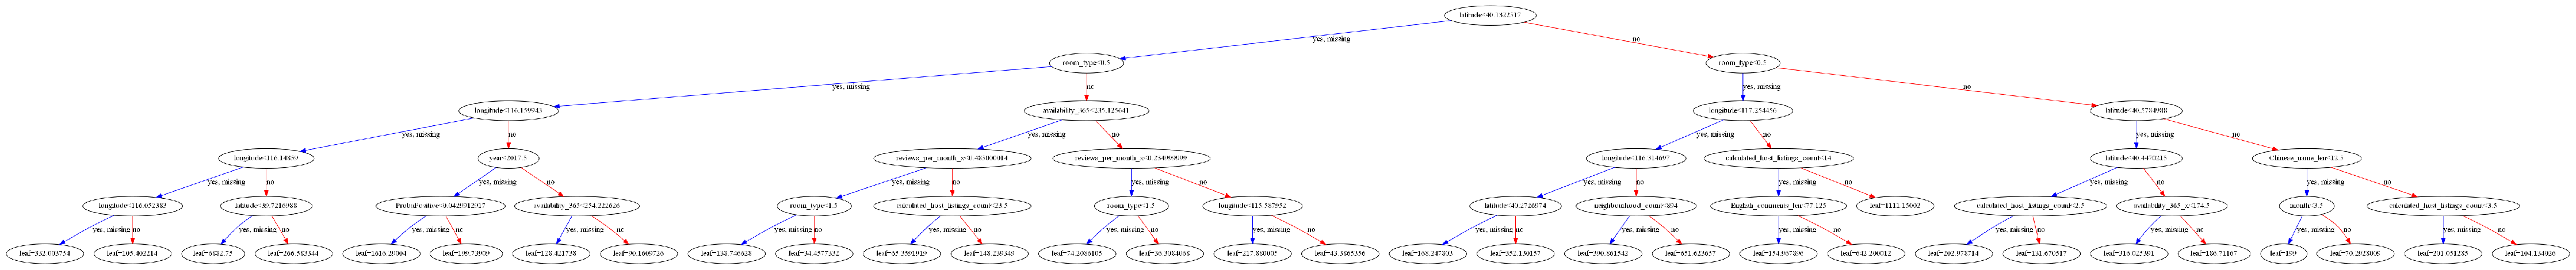

In [368]:
#决策树可视化
xg_reg = xgb.train(params=xgb_param , dtrain=df_matrix, num_boost_round=10) #建模
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

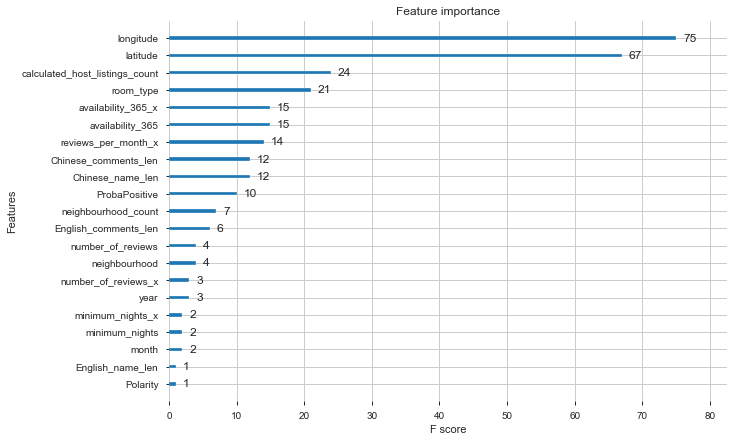

In [385]:
# 显示重要特征
plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 7]
plt.show()

## 3.3 模型调参

### 调节 n_estimators

In [404]:
cv_params = {'n_estimators': [10,15,20,25,30,35,40,50]} #待调节参数,n_estimator是评估器的数量
params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 
          'min_child_weight': 1, 'seed': 0,'subsample': 0.8,
          'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

def tunning(params,cv_params):
    model = xgb.XGBRegressor(**params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, 
                    scoring='r2', cv=5, verbose=0, n_jobs=-1)
    optimized_GBM.fit(X_train, Y_train)
    return optimized_GBM.best_params_,optimized_GBM.best_score_

print(tunning(params,cv_params))

({'n_estimators': 15}, 0.09163060384214497)


### 调节和booster相关参数

In [395]:
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3]}
params = {'learning_rate': 0.1, 'n_estimators': 15, 'max_depth': 5, 
          'min_child_weight': 1, 'seed': 0,
           'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
print(tunning(params,cv_params))

{'max_depth': 4, 'min_child_weight': 1}
0.12265088101571728


In [397]:
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],'subsample': [0.5,0.6,0.7,0.8,0.9,1],'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1]}
params = {'learning_rate': 0.1, 'n_estimators': 15, 'max_depth': 4, 
          'min_child_weight': 1, 'seed': 0,
           'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
print(tunning(params,cv_params))

{'colsample_bytree': 0.7, 'gamma': 0.1, 'subsample': 0.9}
0.1283456358051421


In [403]:
cv_params = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05], 'reg_lambda':[1,0.9,0.8,0.7] }
params = {'learning_rate': 0.1, 'n_estimators': 15, 'max_depth': 4, 
          'min_child_weight': 1, 'seed': 0,
           'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}
print(tunning(params,cv_params))

{'reg_alpha': 0, 'reg_lambda': 1}
0.1283456358051421


### 调节 learning rate

In [400]:
cv_params = {'learning_rate': [0.01, 0.05, 0.07,0.1,0.13,0.15,0.18,0.2]}
params = {'learning_rate': 0.1, 'n_estimators': 15, 'max_depth': 4, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}

print(tunning(params,cv_params))

{'learning_rate': 0.15}
0.13412123423928202


### 参数调优后结果

In [409]:
best_params = {'learning_rate': 0.15, 'n_estimators': 15, 'max_depth': 4, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**params)
model.fit(X_train, Y_train)
# 对训练集和测试集进行评估
score_train=model.score(X_train,Y_train)
score_test=model.score(X_test,Y_test)
print(score_train)
print(score_test)
pred= model.predict(X_test)
print(mean_squared_error(pred,Y_test))
xgb_param = model.get_xgb_params()
cv_results = xgb.cv(dtrain=df_matrix, params=xgb_param, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=0)
cv_results.tail(1)

0.8985572265607505
0.04923171828201267
1366867.6129946948


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
36,976.294434,70.252195,1206.375342,371.984831


参数调整后MSE由1400066下降至1326715；train-rmse-mean	train-rmse-std	test-rmse-mean	test-rmse-std；交叉验证下各项数值均有所下降。


# 4 总结

本文详细地介绍Airbnb数据集的特征工程创建，XGB建模以及调参过程。根据结果显示，调参后的模型能够有效提升回归精度。
但从目前结果来看，仍然存在许多问题。1.训练集与验证集得分差异巨大，可能存在过拟合问题；2.MSE或者RMSE值均偏大，可能与异常值相关；3.调参过程时间较长，可考虑进一步进行特征选择和特征降维，以加快建模和调参速度。后续的方向:1.进一步移除异常值；2.移除权重过大的特征，进一步选择特征，缓解过拟合问题；3.数据标准化后进行PCA降维；4.使用模型融合等集成方法提升精度。